首先，我們需要看看資料的的型態。
在UCI的網站上的data description 有寫到-200代表儀器沒有測量到，為了不影響之後的計算，我把它設成NaN值，並做內插法。
另外因為這是一個時間序列的data, 因此我利用pandas 的function，把date time 作為index。將來可以很方便地去分析跟時間有關的特徵。

In [275]:

import pandas as pd 
import numpy as np
import scipy 
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from datetime import datetime
import matplotlib
import math


data = pd.read_csv('data/AirQualityUCI.csv')


data = data.replace(-200,np.NaN)
data = data.apply(pd.Series.interpolate)
data.drop(data.columns[[-1,-2]],axis=1,inplace=True)

data['date'] = data['Date'] + ' ' + data['Time']

data['date'] = pd.to_datetime(data['date'], format="%d/%m/%Y %H.%M.%S")
data.set_index('date',inplace=True)

#print(data.index)
#print(data.head())


再來我們先看看前三天的污染數值是如何起伏的，讓我們對整個data有個概念。

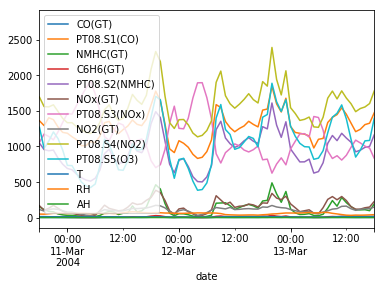

In [276]:
ts = data.plot()
ts.set_xlim(pd.Timestamp('2004-3-10 18:00:00'), pd.Timestamp('2004-3-13 18:00:00'))
plt.show()

我們可以觀察到
     1. 這是一種時間序列的資料型態
     2. CO,NMHC,NOx,NO2 都有certified 的 ground truth 以及某種儀器測出來的值，而O3只有測量儀器，C6H6是只有ground turth。
        這產生了一個問題，到底可不可以信任測量值？
        
我們可以透過相關係數(correlation coefficent)去衡量2.這個問題
相關係數越大（接近1），代表此測量值跟ground truth 有很大的正相關
因此我分別計算這些測量值跟ground truth 的相關係數


In [277]:
CO = data[['CO(GT)','PT08.S1(CO)']]
print(CO.corr())
NMHC = data[['NMHC(GT)','PT08.S2(NMHC)']]
print(NMHC.corr())
NOx = data[['NOx(GT)','PT08.S3(NOx)']]
print(NOx.corr())
NO2 = data[['NO2(GT)','PT08.S4(NO2)']]
print(NO2.corr())


               CO(GT)  PT08.S1(CO)
CO(GT)       1.000000     0.794054
PT08.S1(CO)  0.794054     1.000000
               NMHC(GT)  PT08.S2(NMHC)
NMHC(GT)       1.000000       0.233825
PT08.S2(NMHC)  0.233825       1.000000
               NOx(GT)  PT08.S3(NOx)
NOx(GT)       1.000000     -0.626814
PT08.S3(NOx) -0.626814      1.000000
               NO2(GT)  PT08.S4(NO2)
NO2(GT)       1.000000      0.134203
PT08.S4(NO2)  0.134203      1.000000


除了CO 的測量值可以採用之外，其他的測量值暫時不採用，因為低於0.5可以說幾乎沒有參考的價值了。
而且甚至可以看到負相關的測量值，因此我決定不採用除了CO之外的測量值。除了O3沒有ground truth 沒有辦法。




In [278]:
data.drop(['PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)'],axis=1,inplace=True)



再來我需要對每個小時去計算所謂的Air Quality

我認為空氣品質應該以對人健康的影響為標準，當污染物嚴重影響人體健康時，儘管只有少量的值，只要超過對人體有害的閥值，就應該被視為污染，因此我參考歐盟的空氣污染指標,當污染物剛好等於標準，為1, 0則為0,再做 mapping。在以下網站來看，CO 的標準為10 mg/m3，C6H6的標準為約5 µg/m3，NOx以及NO2為 200 µg/m3, 另外,NMHC 沒有找到標準，而O3則是經過測量工具，因此沒有單位，所以我都將其平均設為0.8，會設為這個值沒有特別原因，只是認為當超過平均值一個程度(1)時，會被視為污染。最後，把所有的出的 mapping 做平均，則為我所謂的空氣污染指標。
http://ec.europa.eu/environment/air/quality/standards.htm




首先我們先對每個column做出相對應的 mapping

In [279]:
def myAirQuality(data_in, standard, isStandard=True):
    if isStandard==True:
        return data_in/standard

    else:
        mean = standard
        return data_in/mean*0.8
    
data['CO_mapping'] = data['CO(GT)'].apply(lambda x: myAirQuality(x, 10))
data['NOx_mapping'] = data['NOx(GT)'].apply(lambda x: myAirQuality(x, 163.3))
data['NO2_mapping'] = data['NO2(GT)'].apply(lambda x: myAirQuality(x, 200))
data['C6H6_mapping'] = data['C6H6(GT)'].apply(lambda x: myAirQuality(x, 0.005))
nmhc_mean = data[['NMHC(GT)']].mean(axis=0,skipna=True)
#print("mean =",nmhc_mean)
data['NMHC_mapping'] = data['NMHC(GT)'].apply(lambda x: myAirQuality(x, nmhc_mean, False))
o3_mean = data[['PT08.S5(O3)']].mean(axis=0,skipna=True)
#print("mean =",o3_mean)
data['O3_mapping'] = data['PT08.S5(O3)'].apply(lambda x: myAirQuality(x, o3_mean, False))
           
print(data['C6H6_mapping'].head())

date
2004-03-10 18:00:00    2380.0
2004-03-10 19:00:00    1880.0
2004-03-10 20:00:00    1800.0
2004-03-10 21:00:00    1840.0
2004-03-10 22:00:00    1300.0
Name: C6H6_mapping, dtype: float64


讓人訝異的是，C6H6的濃度實在超出標準值太多，都達到標準值的千倍以上。


然後我在針對每個columns 做平均



In [280]:
data['AQ'] = data[['CO_mapping','NOx_mapping','NO2_mapping','C6H6_mapping','NMHC_mapping','O3_mapping']].mean(axis=1)
print(data['AQ'].head())

date
2004-03-10 18:00:00    397.211446
2004-03-10 19:00:00    313.729315
2004-03-10 20:00:00    300.447537
2004-03-10 21:00:00    307.175421
2004-03-10 22:00:00    217.092237
Name: AQ, dtype: float64


值相當大，因為C6H6都是幾千倍以上，因此mean受C6H6影響很深

試試看把C6H6也mapping成平均在0.8，另外，為了圖表顯示方便，我們也把溫度以及濕度等等都 normalize 在( 0,1) 之間。

In [281]:
c6h6_mean = data['C6H6(GT)'].mean(axis=0)
data['C6H6_mapping'] = data['C6H6(GT)'].apply(lambda x: myAirQuality(x, c6h6_mean))

data['AQ'] = data[['CO_mapping','NOx_mapping','NO2_mapping','C6H6_mapping','NMHC_mapping','O3_mapping']].mean(axis=1)
print(data['AQ'].head())

data['T'] = data['T']/data['T'].mean()
data['RH'] = data['RH']/100

date
2004-03-10 18:00:00    0.739622
2004-03-10 19:00:00    0.549891
2004-03-10 20:00:00    0.594897
2004-03-10 21:00:00    0.659389
2004-03-10 22:00:00    0.531997
Name: AQ, dtype: float64


現在我們所定義的Air Quality大致上落在0,1之間。其實不管scale到哪個範圍，都沒有關係，因為我們只是想知道他們的走向，以及彼此的相關性，都scale到一個範圍是方便我們觀察。


接下來我們對各種物質做圖，看看每個數值的走向如何，這裡我先採用最一開始的72小時為例，做出圖表

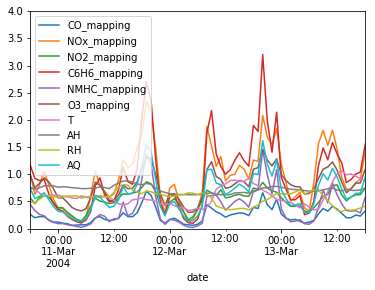

In [282]:
#columns = [c for c in data.columns.tolist() if c != 'PT08.S5(O3)']
columns = ['CO_mapping','NOx_mapping','NO2_mapping','C6H6_mapping','NMHC_mapping','O3_mapping','T','AH','RH','AQ']
data = data[columns]


ts = data.plot()
ts.set_xlim(pd.Timestamp('2004-3-10 18:00:00'), pd.Timestamp('2004-3-13 18:00:00'))
ts.set_ylim(0,4)
plt.show()

其實從圖表可以看出大部分的物質走向是高度相關的。但這只是前72小時，所以並不能下結論。

為了找出每個數值可靠的的相關性，我們可以做每個數值的correlation matrix。

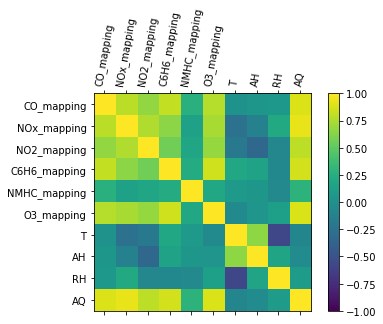

In [283]:
correlations = data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(columns,rotation=80)
ax.set_yticklabels(columns)
#ax.set_xticklabels(rotation=80)
plt.show()

我們可以看到，除了NMHC，CO,NOx,NO2,C6H6, O3 等數值都是正相關。最重要的，是跟ＡＱ(最後一項，座標軸似乎沒有顯示出來)有正相關，因此在做models時，這些數值可以相當程度的參考。

['CO_mapping', 'NOx_mapping', 'NO2_mapping', 'C6H6_mapping', 'NMHC_mapping', 'O3_mapping', 'T', 'AH', 'RH', 'AQ']


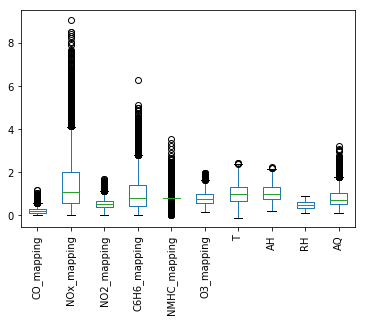

In [284]:
print(columns)
ps = data.plot.box()
ps.set_xticklabels(columns,rotation=90)
plt.show()

從上圖可以得知，這些CO,NOx,NO2這些數據的中位數都落在小於1的地方，可見這些污染源大致上是符合歐盟標準的，除了C6H6超出歐盟標準相當多，但因為剛剛對C6H6做0.8的mapping，因此對於C6H6來講，我們看不出是不是有超標。其他像是O3,NMHC並沒有辦法找到衡量的標準，所以先不討論。


現在我們可以針對每一天的數據，看出每一天每小時會有什麼樣的變化



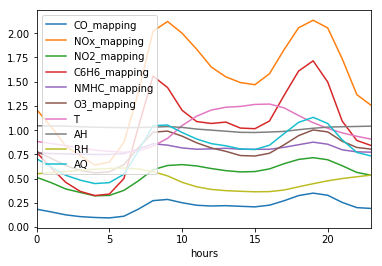

In [285]:
days_hours_trend = data.groupby(data.index.hour).mean()

aa = days_hours_trend.plot()
aa.set_xlabel('hours')
plt.show()

從這張圖表來看，每一天的早上九點以及晚上六點會是污染的巔峰，可以猜測大概是上下班的通勤時間，造成此地區主要的污染。

再來，為了證實此推測，看看每一週的污染變化。


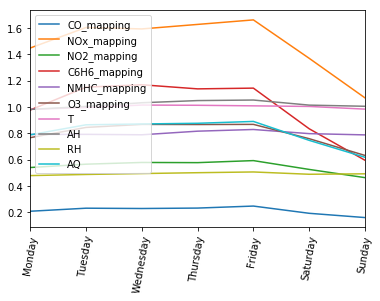

In [286]:
weekdays_trend = data.groupby(data.index.weekday).mean()
aa= weekdays_trend.plot()
weeks_axis= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
aa.set_xticklabels(weeks_axis,rotation=80)
plt.show()

我們可以得到趨勢是，星期六日會是污染的低谷，而星期五會是污染的高峰，這證明了我的推測：此地區的污染跟上班時間與通勤時間有密切關係，因此污染來源大部分來自交通工具的污染。

我們也可以看看每個月的變化

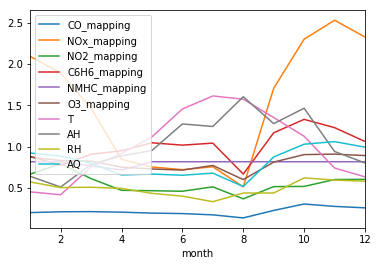

In [287]:
month_trend = data.groupby(data.index.month).mean()
aa = month_trend.plot()
aa.set_xlabel('month')
plt.show()

對每個月的污染做圖，我們可以看到污染在8月有個低谷，推測是歐洲的假期造成此現象。並且，隨著假期結束，在十月時污染會達到一個高峰。







接下來我打算定義我的預測模型以及要預測的問題。

預測問題： 以前九個小時的數據，預測下一小時的AQ
    

我以每10小時為一個window,去做slice,則我們可以得到9347筆training data。取其中的1/5為validation。

In [288]:
train_data = data.as_matrix()
def getTrain(train_data,features_num):

    #print(train_data.shape)
    X_train = []
    Y_train = []
    for i in range(train_data.shape[0]-10):
        X_train.append(train_data[i:i+9,:].reshape(-1))
        Y_train.append(train_data[i+10,features_num-1])

    
    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train).reshape(-1,1)
    #print(Y_train.shape)
    #print(X_train.shape)
    train = np.concatenate((X_train,Y_train),axis=1)
    #print(train.shape)

    np.random.shuffle(train)

    train_num = train.shape[0]-math.floor(train.shape[0]/5)

    X_train = train[:train_num,:features_num*9]
    Y_train = train[:train_num,features_num*9]
    X_validation = train[train_num:,:features_num*9]
    Y_validation = train[train_num:,features_num*9]


    print("X_train shape = ",X_train.shape)
    print("Y_train shape = ",Y_train.shape)
    print("X_validation shape = ",X_validation.shape)
    print("Y_validation shape = ",Y_validation.shape)
    
    return X_train, Y_train, X_validation, Y_validation
    
X_train, Y_train, X_validation, Y_validation = getTrain(train_data,10) 

X_train shape =  (7478, 90)
Y_train shape =  (7478,)
X_validation shape =  (1869, 90)
Y_validation shape =  (1869,)


我採用的是2層hidden layers的NN，並且用relu這個activation，因為我們的需要regress的數值超過0,1這個範圍，所以我選用relu。我也使用dropout 去增加NN的準確性。

Train on 7478 samples, validate on 1869 samples
Epoch 1/100
7478/7478 [==============================] - 1s - loss: 0.1476 - val_loss: 0.0671
Epoch 2/100
7478/7478 [==============================] - 0s - loss: 0.0813 - val_loss: 0.0589
Epoch 3/100
7478/7478 [==============================] - 0s - loss: 0.0768 - val_loss: 0.0565
Epoch 4/100
7478/7478 [==============================] - 0s - loss: 0.0671 - val_loss: 0.0529
Epoch 5/100
7478/7478 [==============================] - 0s - loss: 0.0648 - val_loss: 0.0534
Epoch 6/100
7478/7478 [==============================] - 0s - loss: 0.0661 - val_loss: 0.0538
Epoch 7/100
7478/7478 [==============================] - 0s - loss: 0.0614 - val_loss: 0.0503
Epoch 8/100
7478/7478 [==============================] - 0s - loss: 0.0591 - val_loss: 0.0491
Epoch 9/100
7478/7478 [==============================] - 0s - loss: 0.0577 - val_loss: 0.0517s
Epoch 10/100
7478/7478 [==============================] - 0s - loss: 0.0559 - val_loss: 0.0474
Epoch 11/1

7478/7478 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0388
Epoch 87/100
7478/7478 [==============================] - 0s - loss: 0.0352 - val_loss: 0.0401
Epoch 88/100
7478/7478 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0415
Epoch 89/100
7478/7478 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0413
Epoch 90/100
7478/7478 [==============================] - 0s - loss: 0.0336 - val_loss: 0.0416
Epoch 91/100
7478/7478 [==============================] - 0s - loss: 0.0348 - val_loss: 0.0436
Epoch 92/100
7478/7478 [==============================] - 0s - loss: 0.0338 - val_loss: 0.0409
Epoch 93/100
7478/7478 [==============================] - 0s - loss: 0.0350 - val_loss: 0.0398
Epoch 94/100
7478/7478 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0398
Epoch 95/100
7478/7478 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0403
Epoch 96/100
7478/7478 [==============================] - 0s - 

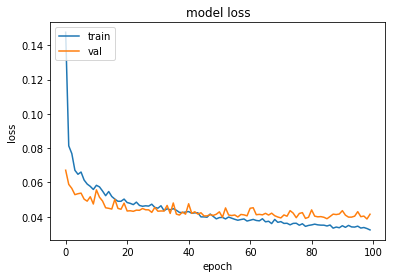

In [289]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import ActivityRegularization,Dropout

columns = data.columns.tolist()

model = Sequential()

model.add(Dense(units=128, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(units=256))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(units=1))
model.add(Activation('relu'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

history = model.fit(X_train, Y_train,
          epochs=100,
          batch_size=128,validation_data=(X_validation, Y_validation))


print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



觀察這些loss，發現在epoch=10左右就收斂的差不多。並且最後的validation loss 在0.4左右。


接下來，我們可以將剛剛觀測到的現象，包括通勤時間、週休二日以及長假對空氣污染的影響考慮進去，這時我們就需要新增月份，weekdays,以及小時等等feature。並且將這些fea
ture都normalize到[0,1]。


In [290]:
data['months'] = data.index.month/12.
#print(data['months'])
data['hours'] = data.index.hour/24.
data['weekdays'] = data.index.weekday/6.
#data['month'] = data.index.month.to_numeric()
#print(data.columns.tolist())
columns = [ c for c in data.columns.tolist() if c != 'AQ']
columns.append('AQ')
data = data[columns]
#print(columns)
print(data.head(10))

                     CO_mapping  NOx_mapping  NO2_mapping  C6H6_mapping  \
date                                                                      
2004-03-10 18:00:00        0.26     1.016534        0.565      1.169056   
2004-03-10 19:00:00        0.20     0.630741        0.460      0.923456   
2004-03-10 20:00:00        0.22     0.802205        0.570      0.884160   
2004-03-10 21:00:00        0.22     1.053276        0.610      0.903808   
2004-03-10 22:00:00        0.16     0.802205        0.580      0.638560   
2004-03-10 23:00:00        0.12     0.545009        0.480      0.461728   
2004-03-11 00:00:00        0.12     0.379669        0.385      0.353664   
2004-03-11 01:00:00        0.10     0.379669        0.380      0.324192   
2004-03-11 02:00:00        0.09     0.275566        0.300      0.225952   
2004-03-11 03:00:00        0.06     0.202082        0.235      0.167008   

                     NMHC_mapping  O3_mapping         T      AH     RH  \
date                     

送入剛剛寫的function 切出training set 跟 validation set。

In [291]:
train_data = data.as_matrix()

X_train2, Y_train2, X_validation2, Y_validation2 = getTrain(train_data,len(columns))

#print (Y_train2)


X_train shape =  (7478, 117)
Y_train shape =  (7478,)
X_validation shape =  (1869, 117)
Y_validation shape =  (1869,)


Train on 7478 samples, validate on 1869 samples
Epoch 1/100
7478/7478 [==============================] - 1s - loss: 0.1623 - val_loss: 0.0516
Epoch 2/100
7478/7478 [==============================] - 0s - loss: 0.0718 - val_loss: 0.0467
Epoch 3/100
7478/7478 [==============================] - 0s - loss: 0.0641 - val_loss: 0.0454
Epoch 4/100
7478/7478 [==============================] - 0s - loss: 0.0620 - val_loss: 0.0427
Epoch 5/100
7478/7478 [==============================] - 0s - loss: 0.0559 - val_loss: 0.0395
Epoch 6/100
7478/7478 [==============================] - 0s - loss: 0.0525 - val_loss: 0.0407
Epoch 7/100
7478/7478 [==============================] - 0s - loss: 0.0504 - val_loss: 0.0391
Epoch 8/100
7478/7478 [==============================] - 0s - loss: 0.0485 - val_loss: 0.0392
Epoch 9/100
7478/7478 [==============================] - 0s - loss: 0.0493 - val_loss: 0.0424
Epoch 10/100
7478/7478 [==============================] - 0s - loss: 0.0477 - val_loss: 0.0366
Epoch 11/10

7478/7478 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0339
Epoch 87/100
7478/7478 [==============================] - 0s - loss: 0.0260 - val_loss: 0.0331
Epoch 88/100
7478/7478 [==============================] - 0s - loss: 0.0260 - val_loss: 0.0351
Epoch 89/100
7478/7478 [==============================] - 0s - loss: 0.0263 - val_loss: 0.0345
Epoch 90/100
7478/7478 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0345
Epoch 91/100
7478/7478 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0340
Epoch 92/100
7478/7478 [==============================] - 0s - loss: 0.0256 - val_loss: 0.0323
Epoch 93/100
7478/7478 [==============================] - 0s - loss: 0.0254 - val_loss: 0.0328
Epoch 94/100
7478/7478 [==============================] - 0s - loss: 0.0261 - val_loss: 0.0345
Epoch 95/100
7478/7478 [==============================] - 0s - loss: 0.0260 - val_loss: 0.0342
Epoch 96/100
7478/7478 [==============================] - 0s - 

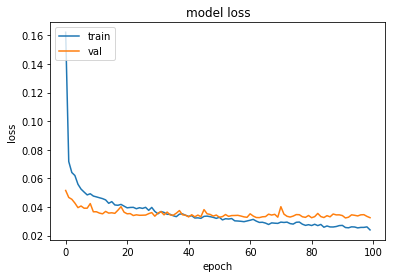

In [292]:
model = Sequential()

model.add(Dense(units=128, input_dim=X_train2.shape[1]))
model.add(Activation('relu'))
model.add(Dense(units=256))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(units=1))
model.add(Activation('relu'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

history = model.fit(X_train2, Y_train2,
          epochs=100,
          batch_size=128,validation_data=(X_validation2, Y_validation2))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

我們可以發現 validation loss 收斂的比較快，且最後落在0.37左右，在同樣的model下，加入時間的feature真的可以提升準確率。證實了我們剛剛觀察到的pattern。


另外我們也可以用Random Forest Regressor 去 predict 我們的Air Quality。我們先試試看沒有加時間元素的data。trees我使用10顆。
且經過幾次實驗之後發現增加數並沒有太好的結果，因此只用10顆。

In [296]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X_train, Y_train)
y_valid = clf.predict(X_validation)
print(y_valid)
loss = (Y_validation-y_valid)**2
loss = np.mean(loss)
print("Random Forsest Mean Square Error : ", loss)

[ 0.53422153  0.75649095  1.16064826 ...,  0.52722551  1.13720193
  0.48255038]
Random Forsest Mean Square Error :  0.0507631685939


得到的loss 大致上是0.05左右，比剛才的NN還要大一些。


再來看看加入時間的features

In [297]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X_train2, Y_train2)
y_valid2 = clf.predict(X_validation2)
print(y_valid2)
loss = (Y_validation2-y_valid2)**2
loss = np.mean(loss)
print("Random Forsest Mean Square Error : ",loss)

[ 1.43301331  0.32349515  0.68741337 ...,  0.65922926  0.53552871
  0.46865735]
Random Forsest Mean Square Error :  0.0327465409989


表現大致上比剛才的NN好一些，推測是因為Tree藉由entropy的大小去處理問題，因此對於month, weekdays, hours這種類似分類的feature，處理的比較拿手。

做個總結:
    
      1. 經過幾項基本的相關係數，我們可以判斷哪一個測量儀器是可靠的，哪些是不可靠的，我們可以看到大概只有CO的測量儀器是可信的。
      2. 我認為空氣品質應該是以危害人體健康的多寡去評估，應此上網查了歐盟的空氣污染標準，歐盟也是根據此方式訂定標準。我的方式是：數據除以歐盟的標準量，因此我們可以得該物質超出標準量多少倍，最後再對每個勿直做平均。但是也有一些例外因素讓我沒有辦法做這樣的評估，因此這些例外我都把他們的平均map到0.8。
      3. 該區苯的含量超出標準許多，是該注意的事情。
      4. 對整個data做correlation matrix，我們可以判斷哪些數值跟我們所定義的Air Quality相關，得出的結果也不意外，因為我的AQ就是取這些feature計算而來的，但是比較不一樣的是，NMHC的相關性明顯較小，也許NMHC的來源跟其他物質不太一樣。
      5. 對小時做圖，可以發現在通勤時間有污染的高峰;對週作圖，可以發現週末是污染的低谷，所以我可以推測該區的污染大致上來自於交通工具的排放，並且可能是位於上班的交通要上附近。對月作圖，可以得出該區人跟大部分的歐洲人相同，有在8,9月放長假的習慣。
      6. 我所採用的預測問題是：取前九個小時去預測下一小時的Air Quality。
      7. validation data 取全部的1/5
      8. NN 與 Random Forest 都發現加入month, weekdays, hours 這些feature後可以提升model的表現。證實上述的看法。